In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.text as mtext
import plotly.express as px
import plotly.graph_objects as go
import random

In [2]:
class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, orig_handle,  **self.text_props)
        handlebox.add_artist(title)
        return title
def rename(df):
    df=df.replace({'subgroup-fair':'Subgroup-Fair','instant-fair':'Instant-Fair','weighted':'AIF360',
                  "fnr":'CaliEqOdds(fnr)', "fpr":'CaliEqOdds(fpr)','EqOddsPostprocessing':"EqOdds"})
    return df
def combine_read(filepath):
    #filepath="data/COMPAS4_metric.csv"
    return pd.concat([pd.read_csv(filepath[0:-4]+"_AIF360.csv"),pd.read_csv(filepath)],ignore_index=True)
#[0:-4]+"_test.csv"
"""
metric=rename(pd.read_csv("data/COMPAS4_metric.csv"))
metric_thresh=rename(pd.read_csv("data/COMPAS4_metric_thresh.csv"))
metric_thresh_AIF360=rename(pd.read_csv("data/AIF3_metric.csv"))
"""

metric=rename(combine_read("data/COMPAS4_metric.csv"))
metric_thresh=rename(combine_read("data/COMPAS4_metric_thresh.csv"))
metric_thresh_AIF360=rename(pd.read_csv("data/AIF3_metric.csv"))

performance = ['IND','SP','SF','INA']
performance1 = np.array([[i,i+'rw'] for i in performance]).flatten().tolist()
performance2 = np.array([[i+'rw'] for i in performance]).flatten().tolist()

methods=['COMPAS',"AIF360","Subgroup-Fair",'Instant-Fair'] #"fnr", "fpr", "weighted" 
metric[['type','thresh','trial']] = metric[['type','thresh','trial']].astype("category")
colors=['r','orange','c','g']

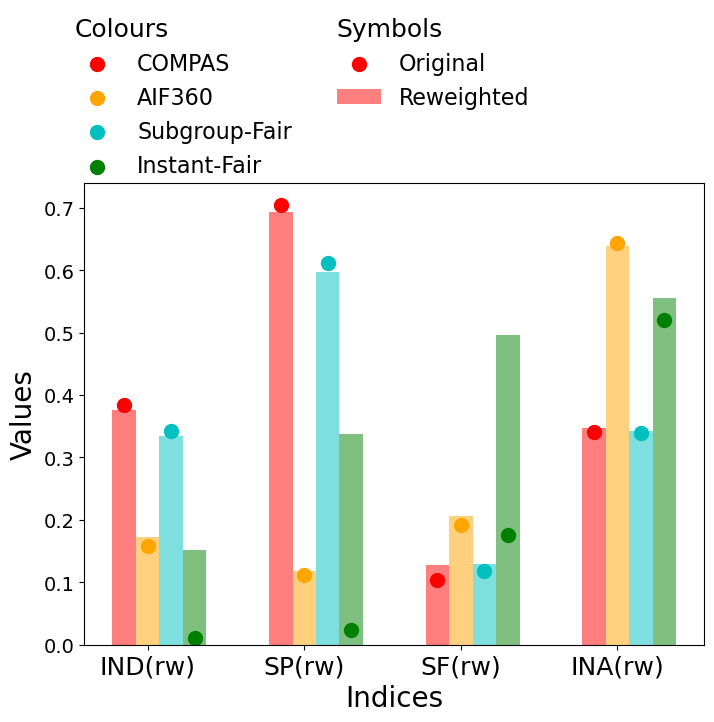

In [3]:
pivot=pd.pivot_table(metric,index=['type','thresh'],values=performance1,aggfunc=[np.mean,np.std])

ind=np.arange(4)
width = 0.15

fig, ax1 = plt.subplots(figsize=(8,6))

i=0
for m in methods:
    sub=[pivot[('mean',p+'rw')][(m,0.5)] for p in performance]
    sub1=[pivot[('mean',p)][(m,0.5)] for p in performance]
    ax1.bar(ind+width*i,sub,width, alpha=0.5,color=colors[i],label=m) #,label=m
    #ax1.scatter(ind+width*i,sub, marker='s',color=colors[i],label=m) #,label=m
    ax1.scatter(ind+width*i,sub1, marker='o',s=100,color=colors[i],label=m)
    i+=1

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(['Colours'] + handles[:4] + ['Symbols'] + handles[:1]+ handles[4:5]+[' '],
          [''] + labels[:4] + [''] + ['Original','Reweighted']+[' '],
           handler_map={str: LegendTitle({'fontsize': 18})},
          bbox_to_anchor=(0.75,1.4), fontsize=16,frameon=False,ncol=2
        )

#ax1.legend(loc='upper left',fontsize=14)
ax1.set_xlabel('Indices', fontsize=20)
ax1.set_ylabel('Values', fontsize=20)

ax1.set_xticks(ind+width)
ax1.set_xticklabels([i+'(rw)' for i in performance], fontsize=18)
ax1.tick_params(axis='y', which='major', labelsize=14)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.savefig("plots/COMPAS4_bar.pdf",bbox_inches='tight')

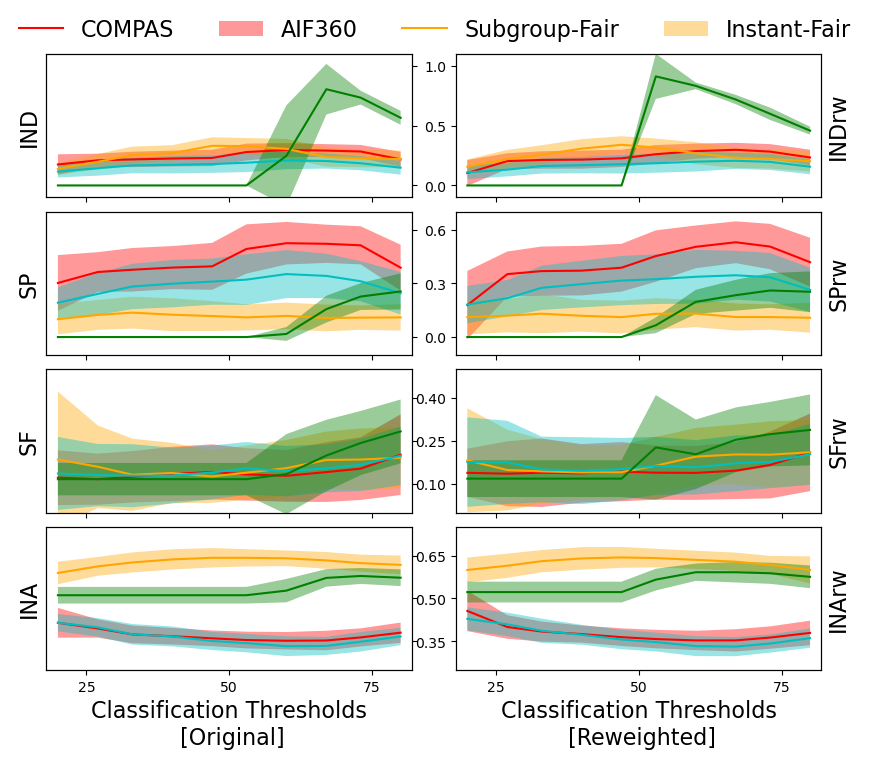

In [4]:
pivot=pd.pivot_table(metric_thresh,index=['type','thresh'],values=performance1,aggfunc=[np.mean,np.std])
all_thresh=sorted(list(set(pivot.index[i][1] for i in range(pivot.shape[0]))))

ylim=[(-0.1,1.1),(-0.1,0.7),(0,0.5),(0.25,0.75)]

fig, axs = plt.subplots(nrows=4, ncols=2,figsize=(10,8))
fig.subplots_adjust(wspace=0.12, hspace=0.1)
for xloc in range(4):
    for yloc in range(2):
        perf=performance1[(xloc*2)+yloc]
        i=0
        for m in methods:
            mean=np.array([pivot[('mean', perf)][(m,thresh)] for thresh in all_thresh])
            std=np.array([pivot[('std', perf)][(m,thresh)] for thresh in all_thresh])
            axs[xloc,yloc].plot(all_thresh,mean,label=m,color=colors[i])
            axs[xloc,yloc].fill_between(all_thresh, mean+std, mean-std, 
                    facecolor=colors[i], alpha = 0.4)
            i+=1
        axs[xloc,yloc].set_ylim(ylim[xloc])
        axs[xloc,yloc].set_yticks(np.linspace(ylim[xloc][0]+0.1,ylim[xloc][1]-0.1,3))
        axs[xloc,yloc].set_xlim(18,82)
        ax2=axs[xloc,yloc].twinx()

        if yloc==0:
            axs[xloc,yloc].set_yticks([])
            axs[xloc,yloc].set_yticklabels([])
            axs[xloc,yloc].set_ylabel(perf, fontsize=16)
            ax2.set_yticklabels([])
            ax2.set_ylim(ylim[xloc])
            ax2.set_yticks(np.linspace(ylim[xloc][0]+0.1,ylim[xloc][1]-0.1,3))
        else:
            # twin y
            ax2.set_yticklabels([])
            ax2.set_yticks([])
            ax2.set_ylabel(perf, fontsize=16)
        
        axs[xloc,yloc].set_xticks([25,50,75])
        if xloc<3:
            axs[xloc,yloc].set_xticklabels([])

axs[3,0].set_xlabel('Classification Thresholds\n [Original]', fontsize=16)
axs[3,1].set_xlabel('Classification Thresholds\n [Reweighted]', fontsize=16)
fig.legend(methods,fontsize=16,bbox_to_anchor =(0.95, 0.95),ncol=4,frameon=False)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.savefig("plots/COMPAS4_lines.pdf",bbox_inches='tight')

C:\Users\zhouq\AppData\Local\Temp\ipykernel_17020\3297215223.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_symbol=metric_symbol.append(dict1,ignore_index=True)
C:\Users\zhouq\AppData\Local\Temp\ipykernel_17020\3297215223.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_symbol=metric_symbol.append(dict2,ignore_index=True)
C:\Users\zhouq\AppData\Local\Temp\ipykernel_17020\3297215223.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_symbol=metric_symbol.append(dict1,ignore_index=True)
C:\Users\zhouq\AppData\Local\Temp\ipykernel_17020\3297215223.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_s

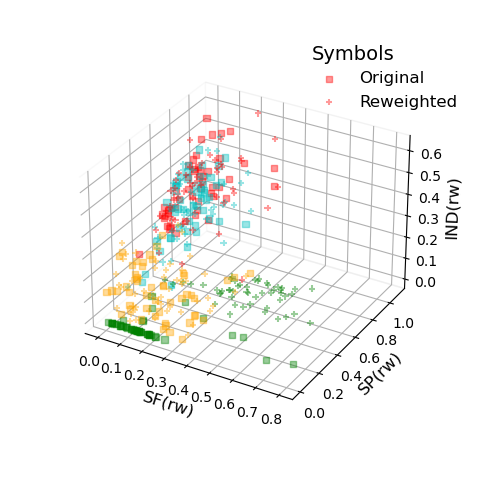

In [5]:
pivot=pd.pivot_table(metric_thresh,index=['type','thresh'],values=performance1,aggfunc=[np.mean,np.std])
all_thresh=sorted(list(set(pivot.index[i][1] for i in range(pivot.shape[0]))))

set(metric_thresh['thresh'])

metric_symbol=pd.DataFrame(columns=performance+['type','thresh','Symbols'])
for i in metric.index.tolist():
    #metric.loc[i]
    dict1={p : metric.loc[i][p] for p in performance+['type','thresh']}
    dict1.update({'Symbols':'Original'})
    dict2={p : metric.loc[i][p+'rw'] for p in performance}
    dict2.update({p : metric.loc[i][p] for p in ['type','thresh']})
    dict2.update({'Symbols':'Reweighted'})
    metric_symbol=metric_symbol.append(dict1,ignore_index=True)
    metric_symbol=metric_symbol.append(dict2,ignore_index=True)

metric_symbol.columns=['IND(rw)', 'SP(rw)', 'SF(rw)', 'INA(rw)', 'type', 'thresh', 'Symbols']
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

i=0
for m in methods:
    tem_ori=metric_symbol[(metric_symbol['type']==m)&(metric_symbol['Symbols']=='Original')]
    tem_rew=metric_symbol[(metric_symbol['type']==m)&(metric_symbol['Symbols']=='Reweighted')]
    ax.scatter(tem_ori['SF(rw)'], tem_ori['SP(rw)'], tem_ori['IND(rw)'], marker='s', color=colors[i],label='Original',alpha=0.4)
    ax.scatter(tem_rew['SF(rw)'], tem_rew['SP(rw)'], tem_rew['IND(rw)'], marker='+', color=colors[i],label='Reweighted',alpha=0.4)
    i+=1

ax.set_xlabel('SF(rw)', fontsize=12)
ax.set_ylabel('SP(rw)', fontsize=12)
ax.set_zlabel('IND(rw)', fontsize=12)
#ax.grid(False)
ax.set_box_aspect(aspect=None, zoom=0.8)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

handles, labels = ax.get_legend_handles_labels()
ax.legend(['Symbols'] + handles[:2], [''] + labels[:2],
          handler_map={str: LegendTitle({'fontsize': 14})},
          bbox_to_anchor=(1,0.95),fontsize=12,frameon=False,ncol=1)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

plt.savefig("plots/COMPAS4_scatter3D.pdf",bbox_inches='tight')

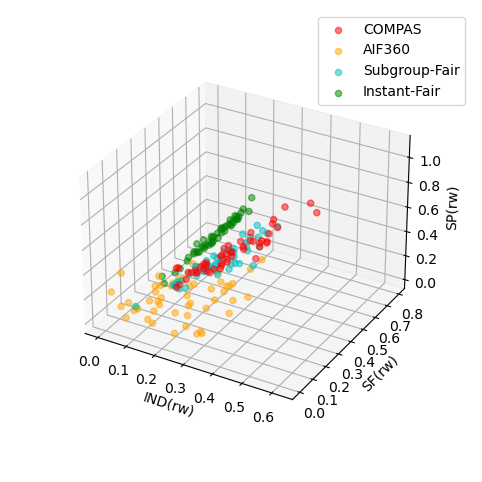

In [6]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

i=0
for m in methods:
    tem=metric_symbol[(metric_symbol['type']==m)&(metric_symbol['Symbols']=='Reweighted')]
    ax.scatter(tem['IND(rw)'], tem['SF(rw)'], tem['SP(rw)'], marker='o', color=colors[i],label=m,alpha=0.5)
    i+=1

ax.set_xlabel('IND(rw)')
ax.set_ylabel('SF(rw)')
ax.set_zlabel('SP(rw)')
#ax.grid(False)
ax.set_box_aspect(aspect=None, zoom=0.8)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend()
#plt.savefig("plots/COMPAS4_scatter3D.pdf",bbox_inches='tight')

In [10]:
a=['hotpink','violet','mediumpurple','purple']
a.reverse()
a

['purple', 'mediumpurple', 'violet', 'hotpink']

In [15]:
colors360=['orange','purple','navy','grey','hotpink']
methods360=["AIF360",'CaliEqOdds(fnr)','CaliEqOdds(fpr)','EqOdds','RejectOption']
pivot=pd.pivot_table(metric_thresh_AIF360,index=['type','thresh'],values=performance2,aggfunc=[np.mean,np.std])
all_thresh=sorted(list(set(pivot.index[i][1] for i in range(pivot.shape[0]))))

metric_mean_reshape=pd.DataFrame(columns=['value','index','type'])
for p in performance1:
    for m in methods360:
        v=[]
        for th in all_thresh[4:7]:
            v+=metric_thresh_AIF360[(metric_thresh_AIF360.type==m)&(metric_thresh_AIF360.thresh==th)][p].tolist()
            #for i in range(len(v)): #+methods360.index(m)*7+7
        metric_mean_reshape=metric_mean_reshape.append({'value':np.mean(v),'index':p,'type':m},ignore_index=True)

fig = px.line_polar(metric_mean_reshape, r="value", theta="index", color="type",line_close=True,
                    color_discrete_sequence=['orange','violet','purple','fuchsia','mediumpurple'],
                    template="plotly_dark",)    

fig.update_layout(
    template=None,
    polar = dict(
        radialaxis = dict(range=[-0.1,0.9], showticklabels=True, ticks="",tickwidth=20,tickvals=[0,0.3,0.6,0.8]),
        radialaxis_tickfont=dict(size=18),
        angularaxis_tickfont=dict(size=20),
        angularaxis = dict(ticks="",
                           ticktext=performance1,
                           tickwidth=10
                          )
        #color_discrete_sequence=['hotpink','violet','mediumpurple','purple','orange']
        #dict(thetaunit = "radians",dtick = 0.785),
    ), #gridwidth=5,gridcolor='black',showticklabels=False,
    showlegend=False,
    margin=dict(l=0, r=0, t=50, b=50)
)
fig.show()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig.write_image("plots/AIF5_radar.pdf")

C:\Users\zhouq\AppData\Local\Temp\ipykernel_17020\922150594.py:13: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\zhouq\AppData\Local\Temp\ipykernel_17020\922150594.py:13: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\zhouq\AppData\Local\Temp\ipykernel_17020\922150594.py:13: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\zhouq\AppData\Local\Temp\ipykernel_17020\922150594.py:13: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\zhouq\AppData\Local\Temp\ipykernel_17020\922150594.py:13: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

In [16]:
metric_reshape=pd.DataFrame(columns=['value','index','Colours','thresh'])
for p in performance1:
    for m in methods360:
        for th in all_thresh[4:7]:
            v=metric_thresh_AIF360[(metric_thresh_AIF360.type==m)&(metric_thresh_AIF360.thresh==th)][p].tolist()
            for i in range(len(v)): #+methods360.index(m)*7+7
                metric_reshape=metric_reshape.append({'value':v[i],'index':performance1.index(p)*45+6+random.random()*33,'Colours':m,'thresh':th},ignore_index=True)

fig = go.Figure(px.scatter_polar(metric_reshape, r="value", theta="index",color="Colours",size_max=40,opacity=0.8,
             symbol='Colours',color_discrete_sequence=['orange','violet','purple','fuchsia','mediumpurple']))
fig.update_layout(
    template=None,
    polar = dict(
        radialaxis = dict(range=[-0.1,0.9], showticklabels=True, ticks="",tickwidth=20,tickvals=[0,0.3,0.6,0.8]),
        radialaxis_tickfont=dict(size=18),
        angularaxis_tickfont=dict(size=20),
        angularaxis = dict(tickvals=[45*i for i in range(8)],ticks="",ticktext=performance1,tickwidth=20,)
        #dict(thetaunit = "radians",dtick = 0.785),
    ), #gridwidth=5,gridcolor='black',showticklabels=False,
    margin=dict(l=0, r=0, t=50, b=50),
    legend_font=dict(size=20),
)
fig.show()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig.write_image("plots/AIF5_scatterPolar.pdf")
#plt.savefig("AIF5_scatterPolar.pdf",bbox_inches='tight')

C:\Users\zhouq\AppData\Local\Temp\ipykernel_17020\3978271381.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\zhouq\AppData\Local\Temp\ipykernel_17020\3978271381.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\zhouq\AppData\Local\Temp\ipykernel_17020\3978271381.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\zhouq\AppData\Local\Temp\ipykernel_17020\3978271381.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\zhouq\AppData\Local\Temp\ipykernel_17020\3978271381.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 